In [1]:
import json
from datetime import datetime
import random
from dataclasses import dataclass, asdict
import os
import shutil
import numpy as np
import cv2
from observer import CalibratedObserver, CameraChange, TrackedObject, MiniMapObject, CalibratedCaptureConfiguration, Transition, distanceFormula
import dma.MechaCombat as mc

In [2]:
MM_TO_INCHES =  0.03937008
INCHES_TO_MM = 25.4

In [3]:
def numpy_serializer(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Type {type(obj)} not serializable")
    
def numpyizeDeserializedCameraChange(deserializedCameraChange: dict):
    if deserializedCameraChange['camName'] is not None:
        deserializedCameraChange['changeContours'] = [np.array(contour, dtype=np.int32) for contour in deserializedCameraChange['changeContours']]
        deserializedCameraChange['after'] = np.array(deserializedCameraChange['after'], dtype=np.int32)
        deserializedCameraChange['before'] = np.array(deserializedCameraChange['before'], dtype=np.int32)
        deserializedCameraChange['lastChange'] = numpyizeDeserializedCameraChange(deserializedCameraChange['lastChange'])
    return CameraChange(**deserializedCameraChange)

In [4]:
@dataclass
class HarmonyObject(TrackedObject):
    oid: str = None
    objectType: str = None
    objectSubType: str = None
    objectKwargs: dict = None

    objectFactories = {"Unit": mc.MechFactories, "Structure": mc.StructureFactories, "Terrain": mc.TerrainFactories}
    
    def __post_init__(self):
        super().__post_init__()
        print(f"Creating {self.objectType} -- {self.objectSubType} -- {self.objectKwargs}")
        self.objectKwargs = {key.lower(): value for key, value in self.objectKwargs.items()}

    def construct(self):
        try:
            factory = self.objectFactories[self.objectType][self.objectSubType]
        except KeyError as ke:
            raise Exception(f"Unrecognized object type and subtype - {self.objectType}-{self.objectSubType}") from ke
        try:
            factory(self.oid, **self.objectKwargs)
        except Exception as e:
            raise Exception(f"Failed to instantiate {factory} object") from e
        mc.GameState.addObject(self.oid, self.objectType)

    @classmethod
    def from_tracked_object(cls,
                            trackedObject: TrackedObject,
                            objectType: str,
                            objectSubType: str,
                            objectKwargs: dict):
        print(f"Creating {objectType} object from {trackedObject}")
        harmonyObject = cls(
            changeSet=trackedObject.changeSet,
            oid=trackedObject.oid,
            objectType=objectType,
            objectSubType=objectSubType,
            objectKwargs=objectKwargs)
        harmonyObject.construct()
        return harmonyObject
        
    def previousVersion(self):
        return TrackedObject({camName: change.lastChange if change is not None else None for camName, change in self.changeSet.items()})

    def rename(self, newName):
        mc.qs.rename_entity(self.oid, newName)
        self.oid = newName

In [5]:
@dataclass
class ObjectAction:
    actor: HarmonyObject
    target: HarmonyObject
    result: str = "null"
    
    def __post_init__(self):
        assert self.rsc is not None, f"Object Actions require a RealSpace Converter"
        if self.target is None:
            self.targetDistance = None
            self.targetRange = None
            self.rangeModifier = None
            self.objMovement = None
            self.aMM = None
            self.targetMovement = None
            self.tMM = None
            self.skill = None
            self.targetNumber = None
            self.gameEvent = None
            return
        # TODO: get distance from graph XY, Elevation instead
        self.targetDistance = self.rsc.distanceBetweenObjects(self.actor, self.target)
        MEDIUM_RANGE = 152  # 6 inches; 152 mm
        LONG_RANGE = 610  # 24 inches; 610 mm
        self.targetRange = "short" if self.targetDistance < MEDIUM_RANGE else "medium" if self.targetDistance < LONG_RANGE else "long"
        match self.targetRange:
            case "short":
                weaponSystems = mc.ShortRangeWeapons
            case "medium":
                weaponSystems = mc.MidRangeWeapons
            case "long":
                weaponSystems = mc.LongRangeWeapons
        self.rangeModifier = weaponSystems(self.actor.oid).Targeting.Modifier.terminant

        self.objMovement = self.rsc.trackedObjectLastDistance(self.actor)
        self.aMM = -1 if self.objMovement is None or self.objMovement < 10 else 0
        self.targetMovement = self.rsc.trackedObjectLastDistance(self.target)
        self.tMM = 0 if self.targetMovement is None or self.targetMovement < 10 else mc.TMM(self.actor.oid).terminant
        self.skill = mc.Skill(self.actor.oid).terminant
        self.otherModifiers = 0
        self.targetNumber = int(self.skill) + self.aMM + self.tMM + self.otherModifiers + self.rangeModifier
        self.gameEvent = None

    def declare(self):
        self.gameEvent = mc.GameEvent.declare_event("Attack", mc.Faction(self.actor.oid).terminant, self.actor.oid, self.target.oid, self.targetNumber, self.result)

    def resolve(self, result):
        self.gameEvent.resolve(result)

    def rename(self, entity, newEntity):
        start_nodes = self.get(start_node=entity)
        for node in start_nodes:
            self.drop(*node)
            self.put(newEntity, node[1], node[2])
            
        end_nodes = self.get(end_node=entity)
        for node in end_nodes:
            self.drop(*node)
            self.put(node[0], node[1], newEntity)

In [6]:
class HarmonyDB(mc.Graph):
    def reset(self, database_file=None):
        with self.DB_LOCK:
            for p in ["harmony.db", "harmony.db-shm", "harmony.db-wal"]:
                try:
                    os.remove(p)
                except FileNotFoundError:
                    pass

            if database_file is not None:
                shutil.copyfile(database_file, "harmony.db")
                self.conn = None
            else:
                with self.cursor() as cur:
                    cur.execute("DROP TABLE IF EXISTS edges;")
                    cur.execute("DROP TABLE IF EXISTS harmony_objects;")
                    cur.execute("""CREATE TABLE edges (
                        start_node TEXT NOT NULL,
                        edge_name TEXT NOT NULL,
                        end_node TEXT NOT NULL,
                        UNIQUE(start_node, edge_name) ON CONFLICT REPLACE);""")
                    cur.execute("""CREATE TABLE harmony_objects (
                        oid TEXT NOT NULL,
                        serialized_harmony_object TEXT NOT NULL,
                        UNIQUE(oid) ON CONFLICT REPLACE);""")
                    self.conn.commit()
                    cur.execute("PRAGMA synchronous=NORMAL")
                    cur.execute("PRAGMA journal_mode=WAL")

    def memorize(self, hObj: HarmonyObject):
        print(f"Memorizing: {hObj.oid}")
        with self.DB_LOCK, self.cursor() as cur:
            serializedHarmonyObject = json.dumps(asdict(hObj), default=numpy_serializer)
            cur.execute(f"INSERT INTO harmony_objects VALUES ('{hObj.oid}', '{serializedHarmonyObject}')")

    def raw_memories(self):
        with self.DB_LOCK, self.cursor() as cur:
            results = cur.execute("SELECT * FROM harmony_objects").fetchall()
        return results
    
    def remember(self):
        raw_memories = self.raw_memories()
        memory = []
        for r in raw_memories:
            mem = json.loads(r[1])
            for cam, cameraChange in mem['changeSet'].items():
                mem['changeSet'][cam] = numpyizeDeserializedCameraChange(cameraChange)
            memory.append(mem)
        return memory

    def rename(self, entity, newEntity):
        super().rename(entity, newEntity)
        with self.DB_LOCK, self.cursor() as cur:
            mem = list(cur.execute(f"SELECT * FROM harmony_objects WHERE oid='{entity}'").fetchall()[0])
            mem[0] = newEntity
            deserializedMem = json.loads(mem[1])
            deserializedMem['oid'] = newEntity
            mem[1] = json.dumps(deserializedMem)
            mem_values = ", ".join([f"'{v}'" for v in mem])
            cur.execute(f"DELETE FROM harmony_objects WHERE oid='{entity}';")
            cur.execute(f"INSERT INTO harmony_objects VALUES ({mem_values});")
        
    def saveGame(self, gameName="harmony"):
        shutil.copyfile("harmony.db", f"{gameName}.harmony")
        
    def loadGame(self, gameName="harmony"):
        self.reset(database_file=f"{gameName}.harmony")

mc.qs.graph = HarmonyDB()

In [43]:
@dataclass()
class HarmonyMachine(CalibratedObserver):
    cc: CalibratedCaptureConfiguration

    def __post_init__(self):
        self.reset()
        self.GameState = mc.GameState
        self.GameEvents = mc.GameEvents

    def getPhase(self):
        return mc.GameState.getPhase()

    def getRoundCount(self):
        return mc.GameState.getRoundCount()

    def reset(self, database_file=None):
        CalibratedObserver.reset(self)
        ObjectAction.rsc = self.cc.rsc
        mc.GameState.reset()

    def __repr__(self):
        return f"HarmonyMachine -- Cycle: {self.cycleCounter:5} -- Objects: {len(self.memory):5} -- {mc.GameState.getPhase():6} -- {self.mode}|{self.state}"
    
    def cycleStatus(self):
        return f"{self}"
    
    def classifyObject(self, objectId: str, objectType: str, objectSubType:str , objectKwargs: dict):
        trackedObject = self.findObject(objectId)
        memoryIndex = self.memory.index(trackedObject)
        harmonyObject = HarmonyObject.from_tracked_object(
            trackedObject, objectType, objectSubType, objectKwargs)
        mc.XYLocation.set_relationship(harmonyObject.oid, self.cc.rsc.changeSetToRealCenter(harmonyObject))
        mc.Footprint.set_relationship(harmonyObject.oid, self.cc.objectToHull(harmonyObject))
        self.memory[memoryIndex] = harmonyObject
        mc.qs.graph.memorize(harmonyObject)
        return harmonyObject

    def captureRealCoord(self, capture):
        """ movement distance this round """
        return [*self.cc.rsc.changeSetToRealCenter(capture), self.objectElevation(capture)]

    def captureSystemCoord(self, capture):
        return [*mc.XYLocation(capture.oid).terminant, mc.Elevation(capture.oid).terminant]

    def commitChanges(self, objDef, overwrite=True):
        try:
            existingIndex = self.memory.index(objDef.previousVersion())
            existingMem = self.memory[existingIndex]
            if (self.expectedChange is not None and existingMem == self.expectedChange.lastChange 
                and self.overlappingChangeSets(self.expectedChange, objDef)
            ):
                print(f"Requested Movement Fulfilled")
                self.clearExpectedMovement()
            print(f"Updating Memory {objDef.oid}")
            self.memory[existingIndex].update(objDef, overwrite=overwrite)
            objDef = self.memory[existingIndex]
        except ValueError:
            print(f"New Memory")
            if mc.GameState.getPhase() != "Add":
                raise Exception("Cannot make new memories outside of Add Phase")
            self.memory.append(objDef)
            existingIndex = len(self.memory) - 1
        self.lastMemory = objDef
        
        self.transitions.append(Transition(
            objDef,
            self.cycleCounter,
            {camName: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
             for camName, cam in self.cc.cameras.items()}))
    
        if isinstance(objDef, HarmonyObject):
            systemCoord = self.captureSystemCoord(objDef)
            realCoord = self.captureRealCoord(objDef)
            delta = [(d1 - d0) for d0, d1 in zip(systemCoord[:2], realCoord[:2])]
            self.declareEvent(
                eventType="Move",
                eventFaction=mc.Faction(objDef.oid).terminant,
                eventObject=objDef.oid,
                eventValue=json.dumps(delta),
                eventTarget=mc.MovementSpeed(objDef.oid).terminant,
                eventResult=json.dumps(self.cc.objectToHull(objDef), default=numpy_serializer))

            print(f"!!! Memorizing: {objDef.oid}")
            mc.qs.graph.memorize(objDef)

        self.mode = "passive"
        
        return objDef

    def takeAction(self, actor, target, result=None):
        return ObjectAction(actor, target, result=result)

    def objectLocation(self, harmonyObject) -> tuple[float, float, float]:
        if mc.GameState.getPhase() == "Move":
            return self.captureRealCoord(harmonyObject)
        else:
            return [*mc.XYLocation(harmonyObject.oid).terminant, mc.Elevation(harmonyObject.oid).terminant]

    def distanceFromRealPoint(self, harmonyObject: HarmonyObject, realPoint: (float, float, float)) -> float:
        """ Returns distance from harmonyObject to realPoint in inches """
        objectPoint = [*mc.XYLocation(harmonyObject.oid).terminant, mc.Elevation(harmonyObject.oid).terminant]
        distance = (distanceFormula(objectPoint[:2], realPoint[:2]) + abs(realPoint[2] - objectPoint[2]) * 2) * MM_TO_INCHES
        return distance

    def objectLastDistance(self, harmonyObject: HarmonyObject):
        if mc.GameState.getPhase() == "Move":
            currentPoint = self.captureRealCoord(harmonyObject)
            delta = [d1 - d0 for d0, d1 in zip(mc.XYLocation(harmonyObject.oid).terminant, currentPoint)]
            return mc.Movement.calculate_movement(entity=harmonyObject.oid, delta=delta)[0]
        else:
            return mc.DistanceMoved(harmonyObject.oid).terminant

    def objectCanMove(self, harmonyObject: HarmonyObject):
        return harmonyObject.oid in mc.Movement.entities()

    def objectCanAct(self, harmonyObject: HarmonyObject):
        return harmonyObject.oid in mc.Weapons.entities()
        
    def objectHasMoved(self, harmonyObject: HarmonyObject):
        if self.objectLastDistance(harmonyObject) > 0.3:
            return True
        return False

    def unitsMovedThisRound(self):
        mechs = self.active_units()
        moved = []
        for m in mechs:
            harmonyObject = self.findObject(m)
            if self.objectHasMoved(harmonyObject):
                moved.append(m)
        return moved

    def declareEvent(cls, eventType: str, eventFaction: str, eventObject: str, eventValue: str, eventTarget: float, eventResult: str):
        print(f"{eventObject} declaring event {eventType}")
        mc.GameState.declareEvent(
            eventType=eventType, eventFaction=eventFaction, eventObject=eventObject, eventValue=eventValue,
            eventTarget=eventTarget, eventResult=eventResult)

    def objectHasDeclared(self, harmonyObject):
        if len(mc.GameEvents.get_existing_declarations(harmonyObject.oid)) > 0:
            return True
        return False

    def unitsDeclaredThisRound(self):
        mechs = mc.Mech.entities()
        declared = []
        for m in mechs:
            harmonyObject = self.findObject(m)
            if self.objectHasDeclared(harmonyObject):
                declared.append(m)
        return declared

    def objectHasResolved(self, harmonyObject):
        for re in mc.GameEvents.get_resolved_events():
            if harmonyObject.oid == re.GameEventObject.terminant:
                return True
        return False

    def actionsToResolve(self):
        declared_actions = len(self.unitsDeclaredThisRound())
        no_actions = len(mc.GameEvents.get_declared_no_action_events())
        return declared_actions - no_actions

    def refreshMovementMaps(self):
        print(f"Building heatmaps")
        start = datetime.utcnow()
        for mech in mc.Mech.entities():
            if self.obj_destroyed(mech):
                continue
            self.buildMovementHeatMap(self.findObject(mech))
        print(f"Took: {(datetime.utcnow() - start).total_seconds():6.3f} s")

    def refreshVisibilityMaps(self):
        print(f"Building heatmaps")
        start = datetime.utcnow()
        for mech in mc.Mech.entities():
            if self.obj_destroyed(mech):
                continue
            self.buildMovementHeatMap(self.findObject(mech))
        print(f"Took: {(datetime.utcnow() - start).total_seconds() / 60}")
    
    def commitAdditions(self):
        for entity in mc.XYLocation.entities():
            harmonyObject = self.findObject(entity)
            mc.XYLocation(entity, self.captureRealCoord(harmonyObject)[:2])
        self.refreshMovementMaps()
        mc.GameState.newPhase("Add")

    def commitMovement(self):
        self.passiveMode()
        mc.GameState.newPhase("Move")

    def resolveRound(self):
        for entity in mc.Movement.entities():
            mc.DistanceMoved.set_relationship(entity, 0)
        self.refreshMovementMaps()
        mc.GameState.newPhase("Action")
        self.trackMode()

    def units(self):
        return mc.Mech.entities()

    def active_units(self):
        return mc.Mech.active_mechs()

    def obj_destroyed(self, oid: str):
        return mc.UnitDamage.is_destroyed(entity=oid)

    def mech_skill(self, mech_oid: str):
        return mc.Skill(mech_oid).terminant

    def objectSpeed(self, mech_oid: str):
        return mc.Movement.MovementSpeed(mech_oid).terminant

    def objectJumpJets(self, mech_oid: str):
        return mc.Movement.JumpJets(mech_oid).terminant

    def factions(self):
        return mc.Faction.terminants()

    def faction(self, oid: str):
        return mc.Faction(oid).terminant

    def object_type(self, oid: str):
        return mc.GameObject(oid).terminant

    def line_of_sight(self, actor: HarmonyObject, target: HarmonyObject, step_size: int = 5):
        actorPersp = [*mc.XYLocation(actor.oid).terminant, mc.Elevation(actor.oid).terminant]
        targetPersp = [*mc.XYLocation(target.oid).terminant, mc.Elevation(target.oid).terminant]

        higherEntity = actorPersp if actorPersp[2] > targetPersp[2] else targetPersp
        higherEntity[2] += 1
        elevationChange = abs(actorPersp[2] - targetPersp[2])
        distanceBetween = sum([(d1 - d0) ** 2 for d0, d1 in zip(actorPersp, targetPersp)]) ** 0.5
        visualObstacles = []
        print(f"== LOS Between {actor.oid} and {target.oid} ({elevationChange}) [{actorPersp} to {targetPersp}]")
        for m in self.memory:
            if m == actor or m == target:
                continue
            memXY = mc.XYLocation(m.oid).terminant
            distanceFromHigher = sum([(d1 - d0) ** 2 for d0, d1 in zip(higherEntity[:2], memXY)]) ** 0.5
            if distanceFromHigher > distanceBetween:
                continue

            losElevationAtDistance = higherEntity[2] - (distanceFromHigher / distanceBetween) * elevationChange
            memElevation = mc.Elevation(m.oid).terminant
            print(f"=== Evaluating {m.oid} -- LOSElev: {losElevationAtDistance} || memElev: {memElevation}")
            if memElevation > losElevationAtDistance:
                visualObstacles.append(m)

        print(f"== LOS Between {actor.oid} and {target.oid}: {[m.oid for m in visualObstacles]}")

        return self.cc.line_of_sight(actor, target, visualObstacles)

    def can_target(self, actor: HarmonyObject, target: HarmonyObject):
        return target.oid != actor.oid and \
            self.object_type(target.oid) in ["Unit", "Structure"] and \
            self.faction(actor.oid) != self.faction(target.oid) and \
            self.line_of_sight(actor, target) and not self.obj_destroyed(target.oid)

    @property
    def objectsAndColors(self):
        factions = self.factions()
        factionColors = {faction: color for faction, color in zip(factions, self.distinct_colors(len(factions)))}
        factionColors["Unaligned"] = (255, 0, 0)
        units = []
        structures = []
        terrain = []
        unknown = []
        for mem in self.memory:
            try:
                if mem.objectType == "Unit":
                    units.append(mem)
                elif mem.objectType == "Structure":
                    structures.append(mem)
                elif mem.objectType == "Terrain":
                    terrain.append(mem)
                else:
                    unknown.append(mem)
            except:
                unknown.append(mem)
        return [
            MiniMapObject(
                mem,
                factionColors[self.faction(mem.oid)]
            ) for mem in units + structures + terrain + unknown]

    def objectElevation(self, obj):
        if mc.GameState.getPhase() == "Move":
            shift_xy = [d0 - d1 for d0, d1 in zip(self.cc.rsc.changeSetToRealCenter(obj), mc.XYLocation(obj.oid).terminant)]
        else:
            shift_xy = (0, 0)
        
        footprint = mc.Footprint(obj.oid).terminant
        if footprint is None:
            footprint = np.array(self.cc.objectToHull(obj), dtype=np.int32)[0]

        return mc.Movement.shifted_location_elevation_difficulty(entity=obj.oid, x=shift_xy[0], y=shift_xy[1], footprint=footprint)[0]
        
    def saveGame(self, gameName="harmony"):
        mc.qs.graph.saveGame(gameName=gameName)
        
    def loadGame(self, gameName="harmony"):
        self.reset()
        mc.qs.graph.loadGame(gameName=gameName)
        self.memory = [HarmonyObject(**mem) for mem in mc.qs.graph.remember()]

    def distinct_colors(self, n=15):
        """ Generate n distinct colors that stand out against brown. """
        if n > 0 and len(getattr(self, "_colors", [])) == n:
            return self._colors
        colors = set()
        contrast_colors = [(139, 69, 19), (204, 100, 2), (0, 255, 0)]
        calc_contrast = lambda r, g, b, bg: abs(r - bg[0]) + abs(g - bg[1]) + abs(b - bg[2])
        while len(colors) < n:
            color = None
            for i in range(100):
                r, g, b = (random.randint(50, 230) for _ in range(3))  # Exclude near black/white
                contrasts = [calc_contrast(r, g, b, c) for c in contrast_colors + list(colors)]
                if sum([contrast > 200 for contrast in contrasts]) >= len(contrast_colors + list(colors)):  # Ensure high contrast
                    color = (r, g, b)
                    break
            if color is None:
                raise Exception(f"Failed to generate color within 100 cycles")
            colors.add((r, g, b))
        self._colors = list(colors)
        return self._colors
    
    def getCameraImagesWithChanges(self, cameraKeys=None, show_interactions=True):
        if cameraKeys is None:
            cameraKeys = self.cc.cameras.keys()

        images = {}
        for camName in cameraKeys:
            cam = self.cc.cameras[camName]
            camImage = cam.cropToActiveZone(cam.mostRecentFrame.copy())
            
            # Paint known objects faction color
            for objAndColor in self.objectsAndColors[::-1]:
                memObj = objAndColor.object
                color = objAndColor.color
                if memObj.changeSet[camName].changeType not in ['delete', None]:
                    memContour = np.array([memObj.changeSet[camName].changePoints], dtype=np.int32)
                    camImage = cv2.drawContours(camImage, memContour, -1, color, -1)
                    if show_interactions and self.objectCouldInteract(memObj):
                        center_x = int(np.mean(memContour[:, :, 0]))  # Mean of x-coordinates
                        center_y = int(np.mean(memContour[:, :, 1]))  # Mean of y-coordinates
                        camImage = cv2.circle(camImage, (center_x, center_y), radius=10, color=(0, 255, 0), thickness=-1)

            # Paint last changes red
            if self.lastChanges is not None and not self.lastChanges.empty:
                lastChange = self.lastChanges.changeSet[camName]
                if lastChange is not None and lastChange.changeType not in ['delete', None]:
                    lastChangeContour = np.array([lastChange.changePoints], dtype=np.int32)
                    camImage = cv2.drawContours(camImage, lastChangeContour, -1 , (0, 0, 127), -1)

            # Paint classification green
            if self.lastClassification is not None and not self.lastClassification.empty:
                lastClass = self.lastClassification.changeSet[camName]
                if lastClass is not None and lastClass.changeType not in ['delete', None]:
                    lastClassContour = np.array([lastClass.changePoints], dtype=np.int32)
                    camImage = cv2.drawContours(camImage, lastClassContour, -1 , (0, 255, 0), -1)

            if self.expectedChange is not None:
                if self.expectedChange.changeSet[camName].changeType not in ['delete', None]:
                    memContour = np.array([self.expectedChange.changeSet[camName].changePoints], dtype=np.int32)
                    center_x = int(np.mean(memContour[:, :, 0]))  # Mean of x-coordinates
                    center_y = int(np.mean(memContour[:, :, 1]))  # Mean of y-coordinates

                    
                    objContour = np.array([self.expectedChange.lastChange.changeSet[camName].changePoints], dtype=np.int32)
                    obj_center_x = int(np.mean(objContour[:, :, 0]))  # Mean of x-coordinates
                    obj_center_y = int(np.mean(objContour[:, :, 1]))  # Mean of y-coordinates
                    camImage = cv2.circle(camImage, (center_x, center_y), radius=10, color=(0, 255, 0), thickness=-1)
                    camImage = cv2.line(
                        camImage,
                        np.array((center_x, center_y), dtype=np.int32),
                        np.array((obj_center_x, obj_center_y), dtype=np.int32),
                        (125, 255, 0), 5)

            camImage = cv2.resize(camImage, [480, 640], interpolation=cv2.INTER_AREA)
            images[camName] = camImage
        return images

    def objectCouldInteract(self, obj: TrackedObject):
        match self.getPhase():
            case "Move":
                canMove = self.objectCanMove(obj) and not self.objectHasMoved(obj)
                return canMove
            case "Declare":
                return self.objectCanAct(obj) and not self.objectHasDeclared(obj)
            case "Action":
                return self.objectCanAct(obj) and not self.objectHasResolved(obj)

    def objectViolatingRules(self, obj: TrackedObject):
        match self.getPhase():
            case "Move":
                return self.objectLastDistance(obj) > self.objectSpeed(obj.oid)
            case _:
                return False

    def buildMiniMap(self, objectsAndColors=None, showInteractions=True):
        miniMap = super().buildMiniMap(objectsAndColors=objectsAndColors)
        
        x, y, w, h = self.cc.realSpaceBoundingBox()

        if showInteractions:
            for memObj in self.memory:
                if self.objectCouldInteract(memObj):
                    hull = self.cc.objectToHull(memObj)
                    center_x = int(np.mean(hull[:, :, 0]) - x)  # Mean of x-coordinates
                    center_y = int(np.mean(hull[:, :, 1]) - y)  # Mean of y-coordinates
                    print(center_x, center_y)
                    miniMap = cv2.circle(miniMap, (center_x, center_y), radius=10, color=(0, 255, 0), thickness=-1)

        if self.expectedChange is not None:
            miniMap = cv2.circle(miniMap, np.array([d - dd for d, dd in zip(self.cc.rsc.changeSetToRealCenter(self.expectedChange), [x, y])], dtype=np.int32), radius=10, color=(125, 255, 0), thickness=-1)
            miniMap = cv2.line(
                miniMap,
                np.array([d - dd for d, dd in zip(self.cc.rsc.changeSetToRealCenter(self.expectedChange), [x, y])], dtype=np.int32),
                np.array([d - dd for d, dd in zip(self.cc.rsc.changeSetToRealCenter(self.expectedChange.lastChange), [x, y])], dtype=np.int32),
                (125, 255, 0), 5)
        return miniMap        
    
    def walkDirection(self, harmonyObject, direction: tuple[float, float], step_size=5):
        costByLocation = {}
        near_moves = []
        med_moves = []
        long_moves = []
        full_moves = []
        distance = sum([d ** 2 for d in direction]) ** 0.5
        movement_speed = mc.Movement.MovementSpeed(harmonyObject.oid).terminant
        dx = (direction[0] / distance) * movement_speed * INCHES_TO_MM
        dy = (direction[1] / distance) * movement_speed * INCHES_TO_MM
        movement_cost = 0
        last_movement_cost = None
        step = 1
        movement_cost, elevation, movements = mc.Movement.calculate_movement(entity=harmonyObject.oid, delta=[dx, dy], max_cost=movement_speed)

        for (x, y), movement_cost, elevation in movements:
            costByLocation[(x, y)] = movement_cost
            if movement_cost < movement_speed * 0.3:
                near_moves.append((x, y))
            elif movement_cost < movement_speed * 0.6:
                med_moves.append((x, y))
            elif movement_cost < movement_speed * 0.75:
                long_moves.append((x, y))
            else:
                full_moves.append((x, y))
            step += step_size
        return costByLocation, near_moves, med_moves, long_moves, full_moves
    
    def buildMovementHeatMap(self, harmonyObject: HarmonyObject):
        hull = self.cc.objectToHull(harmonyObject)
        costByLocation = {}
        near_moves = []
        med_moves = []
        long_moves = []
        full_moves = []

        movementHeatMap = getattr(harmonyObject, "movementHeatMap", {}).get(str(mc.XYLocation(harmonyObject.oid).terminant), None)
        if movementHeatMap is None:
            movement_speed = mc.MovementSpeed(harmonyObject.oid).terminant
            generate_ds = lambda: [[1, 0], [1, 0.5], [1, 1], [0.5, 1], [0, 1], [-0.5, 1], [-1, 1], [-1, 0.5], [-1, 0], [-1, -0.5], [-1, -1], [-0.5, -1], [0, -1], [0.5, -1], [1, -1]]
            path_blocked = {tuple(path): False for path in generate_ds()}
            zeros = np.zeros([1200, 1200, 1], dtype="uint8")
            
            for dx, dy in generate_ds():
                pathCostByLocation, path_near_moves, path_med_moves, path_long_moves, path_full_moves = self.walkDirection(harmonyObject, [dx, dy])
                near_moves.extend(path_near_moves)
                med_moves.extend(path_med_moves)
                long_moves.extend(path_long_moves)
                full_moves.extend(path_full_moves)
                costByLocation = {**costByLocation, **pathCostByLocation}
    
            layer_hulls = []
            for moves, color in zip([near_moves, med_moves, long_moves, full_moves], [(0, 255, 0), (0, 180, 125), (0, 125, 255), (0, 0, 255)]):
                if len(moves) == 0:
                    continue
                image = np.zeros([1200, 1200, 1], dtype="uint8")
                move_hulls = [hull + np.array([x, y], dtype=np.int32) for x, y in moves]
                move_hull = cv2.convexHull(np.vstack(move_hulls))
                layer_hulls.append((move_hull, color))

            image = np.zeros([1200, 1200, 3], dtype="uint8")
            for layer_hull, color in layer_hulls[::-1]:
                image = cv2.drawContours(image, [layer_hull], -1, color, -1)
                
            harmonyObject.movementHeatMap = {str(mc.XYLocation(harmonyObject.oid).terminant): image}
        else:
            image = movementHeatMap

        return image

    def buildMovementMap(self, harmonyObject: HarmonyObject):
        image = np.zeros([1200, 1200, 3], dtype="uint32")
        if self.cc.rsc is None:
            return image
        movementMaps = getattr(self, "movementMaps", {})
        x, y, w, h = self.cc.realSpaceBoundingBox()
        
        minimap = self.buildMiniMap(
            objectsAndColors=[MiniMapObject(mem, (0, 255, 0) if mem.oid == harmonyObject.oid else (0, 0, 255) if self.object_type(mem.oid) == "Unit" else (255, 0, 0)) for mem in self.memory],
            showInteractions=False)

        if movementMaps.get(harmonyObject.oid, (None, None))[0] == mc.XYLocation(harmonyObject.oid).terminant:
            heatMap = movementMaps[harmonyObject.oid][1]
        else:
            heatMap = self.buildMovementHeatMap(harmonyObject)[y:y+h, x:x+w]
            movementMaps[harmonyObject.oid] = (mc.XYLocation(harmonyObject.oid).terminant, heatMap)
            setattr(self, "movementMaps", movementMaps)
    
        # Blend the original image with the overlay using `alpha`
        alpha = 0.4
        return cv2.addWeighted(minimap, alpha, heatMap, 1 - alpha, 0)

    def buildVisibilityMap(self, harmonyObject: HarmonyObject):
        image = np.zeros([1200, 1200, 3], dtype="uint8")
        if self.cc.rsc is None:
            return image

        visibilityMap = getattr(harmonyObject, "visibilityMap", {}).get(str(self.objectLocation(harmonyObject)), None)
        if visibilityMap is None:
            x, y, w, h = self.cc.realSpaceBoundingBox()
    
            hull = self.cc.objectToHull(harmonyObject)
            center = [int(d) for d in self.objectLocation(harmonyObject)[:2]]
    
            for radius, color in zip([42 * INCHES_TO_MM, 24 * INCHES_TO_MM, 6 * INCHES_TO_MM], [(0, 0, 255), (0, 125, 255), (0, 255, 0)]):
                cv2.circle(image, center, int(radius), color, -1)
    
            for target in self.memory:
                if self.can_target(harmonyObject, target):
                    cv2.line(image, center, [int(d) for d in self.objectLocation(harmonyObject)[:2]], color=(0, 0, 0), thickness=2)
    
            image = image[y:y+h, x:x+w]
            harmonyObject.visibilityMap = {str(self.objectLocation(harmonyObject)): image}
        else:
            image = visibilityMap
    
        def select_color(mem):
            if mem.oid == harmonyObject.oid:
                return (0, 255, 0) 
            elif self.object_type(mem.oid) == "Unit":
                if self.faction(harmonyObject.oid) != self.faction(mem.oid):
                    return (0, 0, 255) 
                else:
                    return (125, 255, 0)
            else:
                return (255, 0, 0)
            
        minimap = self.buildMiniMap(
            objectsAndColors=[MiniMapObject(mem, select_color(mem)) for mem in self.memory],
            showInteractions=False)

        alpha = 0.2
        image = cv2.addWeighted(minimap, 1 - alpha, image, alpha, 0)
                
        return image

    def add_footprint(self, hObj: HarmonyObject, camName: str, addition_points: list[tuple[int, int]], margin=50):
        cam = self.cc.cameras[camName]
        change = hObj.changeSet[camName]
        x, y, w, h = hObj.changeSet['0'].clipBox
        adjusted_addition_points = [[pt[0] + x - margin, pt[1] + y - margin] for pt in addition_points]
        adjusted_addition_points = np.int32(adjusted_addition_points)
        height, width = cam.mostRecentFrame.shape[:2]
        blank_image = np.zeros([height, width], np.uint8)
        contour_image = cv2.drawContours(blank_image.copy(), change.changeContours, -1, (255), -1)
        projected_addition_and_contours = cv2.polylines(contour_image, [adjusted_addition_points], isClosed=True, color=(255), thickness=3)
        _, thresh = cv2.threshold(projected_addition_and_contours, 127, 255, 0)
        newChangeContours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        hObj.changeSet[camName].overrideChangeContours(newChangeContours)
        return hObj

    def subtract_footprint(self, hObj: HarmonyObject, camName: str, subtraction_points: list[tuple[int, int]], margin=50):
        cam = self.cc.cameras[camName]
        change = hObj.changeSet[camName]
        print(f"Subtracting: {subtraction_points}")
        x, y, w, h = hObj.changeSet['0'].clipBox
        adjusted_subtraction_points = [[pt[0] + x - margin, pt[1] + y - margin] for pt in subtraction_points]
        adjusted_subtraction_points = np.int32(adjusted_subtraction_points)
        height, width = cam.mostRecentFrame.shape[:2]
        mask = np.ones([height, width], dtype=np.uint8) * 255  # White mask
        contour_image = cv2.drawContours(mask.copy(), [adjusted_subtraction_points], -1, (0), -1)
        print(f"Created contour image")

        existing_contours = cv2.drawContours(np.zeros([height, width], np.uint8), change.changeContours, -1, (255), -1)
        projected_subtraction_and_contours = cv2.bitwise_and(existing_contours, existing_contours, mask=contour_image)
        print(f"Created projection")

        _, thresh = cv2.threshold(projected_subtraction_and_contours, 127, 255, 0)
        newChangeContours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        hObj.changeSet[camName].overrideChangeContours(newChangeContours)
        return hObj

Starting Cycle HarmonyMachine -- Cycle:     0 -- Objects:     0 -- Add    -- passive|idle


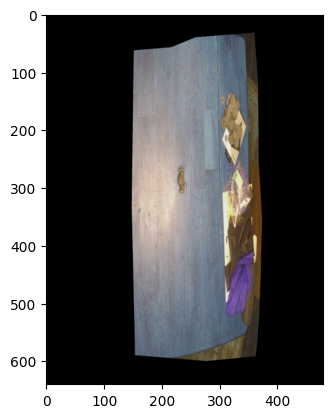

In [44]:
if __name__ == "__main__":
    from matplotlib import pyplot as plt
    cc = CalibratedCaptureConfiguration()
    hm = HarmonyMachine(cc=cc)
    hm.cycle()
    plt.imshow(hm.getCameraImagesWithChanges()['0'])

In [9]:
if __name__ == "__main__":
    for i in range(3):
        hm.cycleForChange()
    for i in range(3):
        hm.cycle()

    hm.classifyObject(hm.memory[0].oid, objectType="Unit", objectSubType="Kingfisher Prime", objectKwargs={"Faction": "Foo", "Skill": 4})
    hm.memory[0].rename("Gypsy Danger")
    hm.classifyObject(hm.memory[1].oid, objectType="Unit", objectSubType="Atlas", objectKwargs={"Faction": "Bar", "Skill": 4})
    hm.memory[1].rename("Cherno")
    plt.imshow(hm.getCameraImagesWithChanges()['0'])

In [10]:
if __name__ == "__main__":
    from IPython.display import display 
    print(f"Saving game with {len(hm.memory)} memories")
    hm.saveGame()

Reset Game Engine:



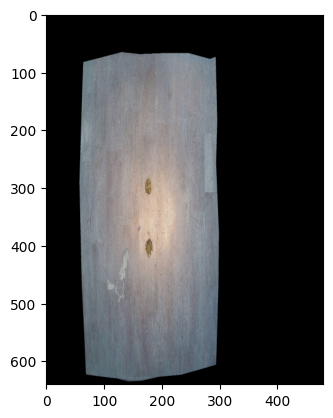

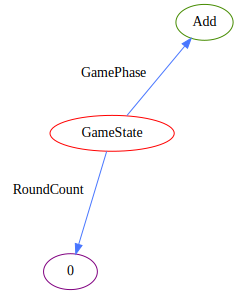

Loading game...
Creating Unit -- Kingfisher Prime -- {'faction': 'Foo', 'skill': 4}
Creating Unit -- Atlas -- {'faction': 'Bar', 'skill': 4}
Reloaded Game Engine:
HarmonyObject(changeSet={'0': (move) [np.float32(630.0), np.float32(627.0)] by 69.0,71.0}, oid='Gypsy Danger', objectType='Unit', objectSubType='Kingfisher Prime', objectKwargs={'faction': 'Foo', 'skill': 4})
HarmonyObject(changeSet={'0': (add) [np.float32(758.0), np.float32(649.0)] by 65.0,71.0}, oid='Cherno', objectType='Unit', objectSubType='Atlas', objectKwargs={'faction': 'Bar', 'skill': 4})


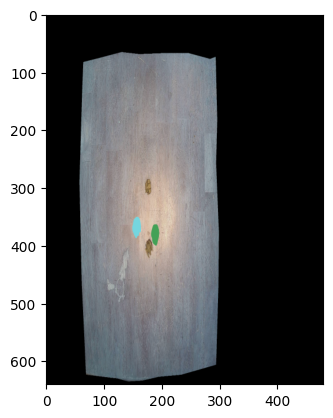

In [11]:
if __name__ == "__main__":
    hm.reset()
    print("Reset Game Engine:")
    print("\n".join([f"{m}" for m in hm.memory]))
    plt.imshow(hm.getCameraImagesWithChanges()['0'])
    plt.show()
    display(mc.qs.render())
    print("Loading game...")
    hm.loadGame()
    print("Reloaded Game Engine:")
    print("\n".join([f"{m}" for m in hm.memory]))
    plt.imshow(hm.getCameraImagesWithChanges()['0'])
    plt.show()